# 데이터

In [1]:
# 라이브러리 불러오기
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

import re
from collections import Counter
import sentencepiece as spm
from konlpy.tag import Okt
from konlpy.tag import Mecab
import csv 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [2]:
# 한글 폰트에 문제가 생겼을 때

# 한글 폰트 설치
!apt-get update -qq
!apt-get install -qq fonts-nanum

# 설치한 폰트를 matplotlib에서 사용할 수 있도록 설정
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# 나눔 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 폰트 매니저에 폰트 추가
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')  # 폰트 설정

## 데이터 업로드

#### 학습 데이터 불러오기

프롬프트로 생성된 '일반 대화' 합성 데이터와 원본 데이터가 합쳐진 파일

In [3]:
train_data_path ="../data/conversations.csv"
train_data = pd.read_csv(train_data_path)
# 원본 데이터 저장
origin_data = train_data

In [4]:
train_data.sample(10)

,idx,class,conversation
322,322,기타 괴롭힘 대화,원숭이 엉덩이는 빨개 빨가면 사과 사과는 맛있어 맛있으면 바나나 야 홍당무 사과는 ...
3994,3994,갈취 대화,야 꼬마\n네? 저요? \n그래 너\n왜. 왜요? \n왜요? 말 다 했냐 지금. 나...
404,404,협박 대화,지금 핵무기발사 비밀번호를 말해라\n나는 절대 핵무기발사 비밀번호를 알려줄수 없다\...
351,351,직장 내 괴롭힘 대화,김대리 이따가 퇴근 후에 뭐 일 있나?\n할 일이 조금 있기는 합니다\n그건 다음으...
4360,4360,일반 대화,주말에 주로 뭐 해?\n집에서 쉬거나 산책해.\n주말에 주로 뭐 해?\n집에서 쉬거...
372,372,갈취 대화,조용히 해. 소리 지르면 죽는다.\n누.누구.세요? 왜 이러세요.\n닥치고 당장 뒤...
4795,4795,직장 내 괴롭힘 대화,요즘 신입은 왜들이래?\n네?\n선배 어려워하지도 않고 요즘은 다들 말대답이나 하고...
3699,3699,직장 내 괴롭힘 대화,이게 보고서라고 들고온거야?\n말씀해주신 내용은 다 적었습니다. 수정할게 있으시면 ...
552,552,협박 대화,지금 남자친구랑 헤어지고 나한테 돌아와.\n내가 왜? 싫어. 지금 남자친구랑 안헤어...
1631,1631,직장 내 괴롭힘 대화,이거 급한거니까 최대한 빨리 처리해줘\n아.네.\n이제 퇴근시간이 되어서 저 퇴근해...


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4950 entries, 0 to 4949
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   idx           4950 non-null   int64 
 1   class         4950 non-null   object
 2   conversation  4950 non-null   object
dtypes: int64(1), object(2)
memory usage: 116.1+ KB


## EDA
### 문장 기준 분석

In [6]:
# 클래스 별 대화 확인해보기
class_counts = train_data.groupby('class').size()
class_counts

class
갈취 대화           981
기타 괴롭힘 대화      1094
일반 대화          1000
직장 내 괴롭힘 대화     979
협박 대화           896
dtype: int64

In [7]:
# 대화(X)와 레이블(y)로 나누기
X_train = train_data['conversation']
y_train = train_data['class']

#### 길이 분포 확인

In [8]:
# 길이 분포 확인하기
print('Data Information')
print('-'*50)
print('Conversations :',X_train.shape)
print('Label :',y_train.shape)
print('Label Type:', set(y_train))
print('-'*50)
num_classes = 4
print('The number of classes : {}'.format(num_classes))
print('-'*50)
print('Max Length :{}'.format(max(len(l) for l in X_train)))
print('Average Length :{}'.format(sum(map(len, X_train))/len(X_train)))

Data Information
--------------------------------------------------
Conversations : (4950,)
Label : (4950,)
Label Type: {'협박 대화', '일반 대화', '기타 괴롭힘 대화', '갈취 대화', '직장 내 괴롭힘 대화'}
--------------------------------------------------
The number of classes : 4
--------------------------------------------------
Max Length :874
Average Length :232.0210101010101


#### 클래스 별 분포 확인

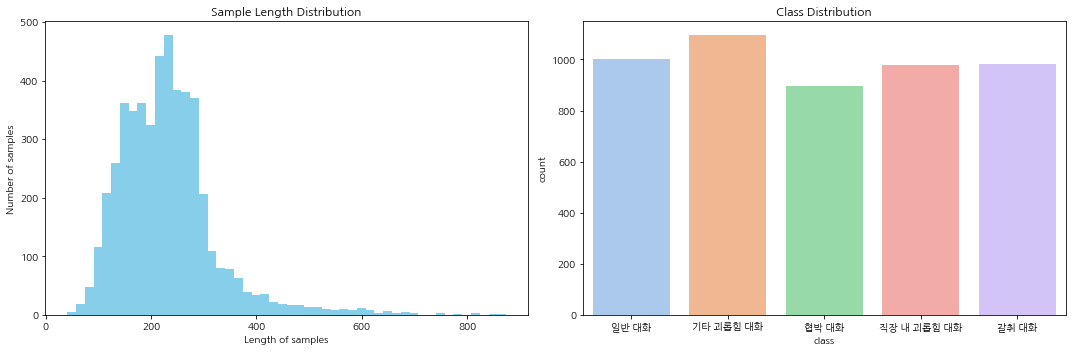

In [9]:
# 두 서브플롯 생성하기
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# 샘플 길이의 히스토그램
axes[0].hist([len(s) for s in X_train], bins=50, color='skyblue')
axes[0].set_xlabel('Length of samples')
axes[0].set_ylabel('Number of samples')
axes[0].set_title('Sample Length Distribution')

# 클래스별 샘플 수 플롯
sns.countplot(x=y_train, ax=axes[1], palette='pastel')
axes[1].set_title('Class Distribution')

# 레이아웃 조정하기
plt.tight_layout()

# 플롯 표시하기
plt.show()

#### 클래스 별 길이 분포 확인

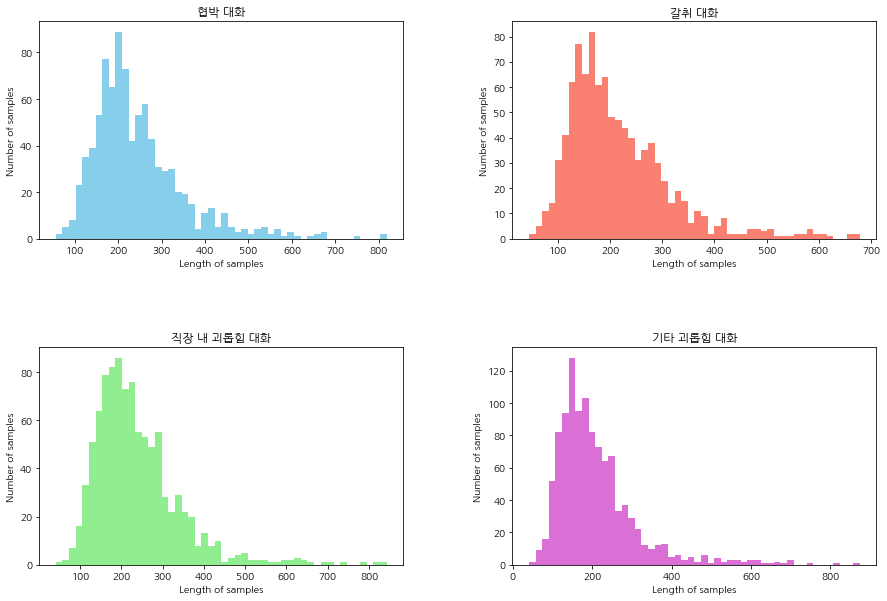

In [10]:
# 서브플롯 생성하기
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# 샘플 길이의 히스토그램 그리기

# 협박 대화
axes[0][0].hist([len(s) for s in train_data['conversation'][train_data['class']=='협박 대화']],
                bins=50, color='skyblue')
axes[0][0].set_xlabel('Length of samples')
axes[0][0].set_ylabel('Number of samples')
axes[0][0].set_title('협박 대화')

# 갈취 대화
axes[0][1].hist([len(s) for s in train_data['conversation'][train_data['class']=='갈취 대화']],
                bins=50, color='salmon')
axes[0][1].set_xlabel('Length of samples')
axes[0][1].set_ylabel('Number of samples')
axes[0][1].set_title('갈취 대화')

# 직장 내 괴롭힘 대화
axes[1][0].hist([len(s) for s in train_data['conversation'][train_data['class']=='직장 내 괴롭힘 대화']],
                bins=50, color='lightgreen')
axes[1][0].set_xlabel('Length of samples')
axes[1][0].set_ylabel('Number of samples')
axes[1][0].set_title('직장 내 괴롭힘 대화')

# 기타 괴롭힘 대화
axes[1][1].hist([len(s) for s in train_data['conversation'][train_data['class']=='기타 괴롭힘 대화']],
                bins=50, color='orchid')
axes[1][1].set_xlabel('Length of samples')
axes[1][1].set_ylabel('Number of samples')
axes[1][1].set_title('기타 괴롭힘 대화')

plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

### 단어 기준 분석
Okt 토크나이저로 형태소 분석

In [11]:
# Okt 토크나이저 활용하여 단어 추출
okt=Okt()

형태소 추출 함수 정의

In [12]:
# 텍스트 전처리 함수 정의하기 (특수문자 제거하기)
# 전처리 없이 토큰화할 경우 상위 토큰들이 대부분 특수문자였음
def preprocess_text(text):
    # 특수문자를 공백으로 바꾸기
    text = re.sub(r"([\n?.!,])", " ", text)
    
    # (ㄱ-ㅎ, ㅏ-ㅣ)를 제외한 모든 문자를 없애기
    text = re.sub("[^ㄱ-ㅣ가-힣]", "", text)
    return text

In [13]:
# 형태소를 추출하는 함수 정의하기
def extract_morphs(conversations):
    all_morphs = []
    for conversation in conversations:
        conversation = preprocess_text(conversation)
        morphs = okt.morphs(conversation)
        all_morphs.extend(morphs)
    morph_counter = Counter(all_morphs)
    return morph_counter

In [14]:
# 명사를 추출하는 함수 정의하기
def extract_nouns(conversations):
    all_nouns = []
    for conversation in conversations:
        conversation = preprocess_text(conversation)
        nouns = okt.nouns(conversation)
        all_nouns.extend(nouns)
    noun_counter = Counter(all_nouns)
    return noun_counter

In [15]:
# 상위 10개의 명사와 형태소를 시각화하는 함수
def plot_top_10(noun_data, morph_data, title_noun, title_morph):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # 상위 10개의 명사
    top_10_nouns = noun_data.head(10)
    axs[0].bar(top_10_nouns['Noun'], top_10_nouns['Frequency'], color='skyblue')
    axs[0].set_title(title_noun)
    axs[0].set_xlabel('Noun')
    axs[0].set_ylabel('Frequency')
    axs[0].tick_params(axis='x', rotation=45)

    # 상위 10개의 형태소
    top_10_morphs = morph_data.head(10)
    axs[1].bar(top_10_morphs['Morph'], top_10_morphs['Frequency'], color='lightgreen')
    axs[1].set_title(title_morph)
    axs[1].set_xlabel('Morph')
    axs[1].set_ylabel('Frequency')
    axs[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

#### 클래스 별 사용 단어 비교

In [16]:
# 대화 데이터를 각 클래스별로 나누기
classes = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화']
class_data = {cls: train_data[train_data['class'] == cls] for cls in classes}

In [ ]:
# 각 클래스별 명사와 형태소를 추출
class_noun_counters = {cls: extract_nouns(data['conversation']) for cls, data in class_data.items()}
class_morph_counters = {cls: extract_morphs(data['conversation']) for cls, data in class_data.items()}

In [ ]:
# 각 클래스별 명사와 형태소 통계를 데이터프레임으로 전환하기
class_noun_stats = {cls: pd.DataFrame(counter.items(), columns=['Noun', 'Frequency']).sort_values(by='Frequency', ascending=False) for cls, counter in class_noun_counters.items()}
class_morph_stats = {cls: pd.DataFrame(counter.items(), columns=['Morph', 'Frequency']).sort_values(by='Frequency', ascending=False) for cls, counter in class_morph_counters.items()}

In [ ]:
# 각 클래스별 상위 10개의 명사와 형태소를 2x2 서브플롯 형태로 시각화하기
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
plot_titles = {
    '협박 대화': ['Top 10 Nouns in Threatening Conversation', 'Top 10 Morphs in Threatening Conversation'],
    '갈취 대화': ['Top 10 Nouns in Extortion Conversation', 'Top 10 Morphs in Extortion Conversation'],
    '직장 내 괴롭힘 대화': ['Top 10 Nouns in Workplace Harassment', 'Top 10 Morphs in Workplace Harassment'],
    '기타 괴롭힘 대화': ['Top 10 Nouns in Other Harassment', 'Top 10 Morphs in Other Harassment']
}

for i, (cls, noun_data) in enumerate(class_noun_stats.items()):
    morph_data = class_morph_stats[cls]
    plot_top_10(noun_data, morph_data, plot_titles[cls][0], plot_titles[cls][1])

plt.tight_layout()
plt.show()

#### 화자 별 사용 단어 비교

화자 A, B 두 명이라고 가정. 각각이 사용한 명사, 형태소 비교

In [ ]:
# A와 B의 대화를 담을 리스트 초기화하기
A_conversations = []
B_conversations = []

In [ ]:
# 대화 열을 반복하면서 각 대화를 분할하기
for conversation in train_data['conversation']:
    try:
        lines = conversation.split('\n')
        # 홀수 줄은 A, 짝수 줄은 B에 추가하기
        A_conv = '\n'.join([line for idx, line in enumerate(lines) if idx % 2 == 0])
        B_conv = '\n'.join([line for idx, line in enumerate(lines) if idx % 2 == 1])
        A_conversations.append(A_conv)
        B_conversations.append(B_conv)
    except ValueError:
        # 대화가 정확히 두 부분으로 나뉘지 않는 경우 처리하기
        A_conversations.append(conversation)
        B_conversations.append('')

In [ ]:
# A와 B를 위한 새로운 데이터프레임 생성하기
A_data = pd.DataFrame({'idx': train_data['idx'], 'class': train_data['class'], 'conversation': A_conversations})
B_data = pd.DataFrame({'idx': train_data['idx'], 'class': train_data['class'], 'conversation': B_conversations})

In [ ]:
# A의 head() 출력하기
print("A 데이터셋의 첫 5개 행:")
A_data.head()

In [ ]:
# B의 head() 출력하기
print("B 데이터셋의 첫 5개 행:")
B_data.head()

In [ ]:
# A와 B의 명사 추출하기
A_noun_counters = {cls: extract_nouns(A_data['conversation']) for cls, data in class_data.items()}
B_noun_counters = {cls: extract_nouns(B_data['conversation']) for cls, data in class_data.items()}

In [ ]:
# A와 B의 형태소 추출하기
A_morph_counters = {cls: extract_morphs(A_data['conversation']) for cls, data in class_data.items()}
B_morph_counters = {cls: extract_morphs(B_data['conversation']) for cls, data in class_data.items()}

In [ ]:
# 명사 통계를 데이터프레임으로 전환하기
A_noun_stats = {cls: pd.DataFrame(A_noun_counters.items(), columns=['Noun', 'Frequency']).sort_values(by='Frequency', ascending=False) for cls, counter in class_noun_counters.items()}
B_noun_stats = {cls: pd.DataFrame(B_noun_counters.items(), columns=['Morph', 'Frequency']).sort_values(by='Frequency', ascending=False) for cls, counter in class_morph_counters.items()}

In [ ]:
# 형태소 통계를 데이터프레임으로 전환하기
A_morph_stats = {cls: pd.DataFrame(A_noun_counters.items(), columns=['Morph', 'Frequency']).sort_values(by='Frequency', ascending=False) for cls, counter in class_morph_counters.items()}
B_morph_stats = {cls: pd.DataFrame(B_noun_counters.items(), columns=['Morph', 'Frequency']).sort_values(by='Frequency', ascending=False) for cls, counter in class_morph_counters.items()}

In [ ]:
# A와 B 데이터의 상위 10개 명사 및 형태소 시각화
# A 데이터의 상위 10개의 명사와 형태소를 서브플롯으로 그리기
plot_top_10(A_noun_stats, A_morph_stats, 'Top 10 Nouns in A Data', 'Top 10 Morphs in A Data')
plot_top_10(B_noun_stats, B_morph_stats, 'Top 10 Nouns in B Data', 'Top 10 Morphs in B Data')

#### 분석 결과 바탕으로 불용어 리스트 생성

기존 불용어 리스트

In [ ]:
# 불용어 리스트 불러오기
origin_stopwords_path = "stopwords.txt"
with open(stopwords_path, 'r', encoding='utf-8') as file:
    stopwords = file.read().splitlines()
stopwords

추가 불용어 리스트

In [ ]:
# 추가 불용어 목록
additional_stopwords = [
    '것', '안', '못', '왜', '이', '저', '그', '사람', '너', '저희', '우리', '나', '너희', '당신',
    '하지만', '그리고', '거나', '그러나', '그러면', '그런데', '그러므로', '그래서', '그럼', '근데', '그래',
    '즉', '따라서', '이와', '여기', '저기', '거기', '이곳', '그곳', '저곳', '거기', '하나', '둘', '셋', '넷',
]
# 추가 불용어를 기본 불용어 사전에 추가하기
stopwords.update(additional_stopwords)

In [ ]:
stopwords_path = "ko_stopwords.txt"
with open(stopwords_path, 'r', encoding='utf-8') as file:
    stopwords = file.read().splitlines()
stopwords